# DerivXY

#### Last updated: December 27, 2024

#### Load the packages

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt

import jax
from jax import jit
import jax.numpy as jnp

#use this command if double precision is needed
#jax.config.update("jax_enable_x64", True)

#### Analytical solution

In [2]:
nx = 256
ny = 256
nz = 256

x = np.linspace(0, 2 * np.pi, nx, endpoint=False)
y = np.linspace(0, 2 * np.pi, ny, endpoint=False)

#Create 2D meshgrid
x2d, y2d = np.meshgrid(x, y)

#Repeat 2D field as 3D
x3d = np.repeat(x2d[:, :, np.newaxis], nz, axis=2)
y3d = np.repeat(y2d[:, :, np.newaxis], nz, axis=2)

#Analytical derivatives
u = np.sin(x3d) * np.cos(y3d)
dudx_true = np.cos(x3d) * np.cos(y3d)
dudy_true = -np.sin(x3d) * np.sin(y3d)

#### Numpy-based derivative function

In [3]:
def MLp_Derivxy(x):
    nx, ny, nz = x.shape
    
    # Generate frequency bins
    kx = np.fft.fftfreq(nx, 1 / nx)  # Shape: (nx,)
    ky = np.fft.rfftfreq(ny, 1 / ny)  # Shape: (ny // 2 + 1,)

    # Explicitly set Nyquist frequencies to 0
    kx[nx // 2] = 0  # Nyquist frequency for x-direction
    if ny % 2 == 0:  # Only set Nyquist in y-direction if ny is even
        ky[ny // 2] = 0  # Nyquist frequency for y-direction
        
    # Perform FFT
    fu = np.fft.rfft2(x, axes=(0, 1))  # Shape: (nx, ny // 2 + 1, nz)

    # Align kx to the second axis
    kx2 = ky[None, :, None]  # Shape: (1, ny // 2 + 1, 1)
    kx2 = np.broadcast_to(kx2, (nx, ny // 2 + 1, nz))  # Shape: (nx, ny // 2 + 1, nz)

    # Align ky to the first axis
    ky2 = kx[:, None, None]  # Shape: (nx, 1, 1)
    ky2 = np.broadcast_to(ky2, (nx, ny // 2 + 1, nz))  # Shape: (nx, ny // 2 + 1, nz)

    # Compute derivatives
    dudx = np.fft.irfft2(1j * kx2 * fu, axes=(0, 1))  # Shape: (nx, ny, nz)
    dudy = np.fft.irfft2(1j * ky2 * fu, axes=(0, 1))  # Shape: (nx, ny, nz)

    return dudx, dudy

#### JAX-based derivative function

In [4]:
def JLp_Derivxy(u, opt1, opt2):
    nx, ny, nz = u.shape

    # Generate frequency bins
    kx = jnp.fft.fftfreq(nx, 1/nx)   # Shape: (nx,)
    ky = jnp.fft.rfftfreq(ny, 1/ny)  # Shape: (ny // 2 + 1,)
    
    # Explicitly set Nyquist frequencies to 0
    kx = kx.at[nx // 2].set(0)  # Nyquist in x-direction
    ky = ky.at[ny // 2].set(0)  # Nyquist in y-direction
    
    if opt1 == 1:
        # Perform FFT along the first two axes
        fu = jnp.fft.rfft2(u, axes=(0, 1))  # Shape: (nx, ny // 2 + 1, nz)
    else: 
        # Do not perform FFT
        fu = u

    if opt2 == 1 or opt2 == 3:
        kx2  = ky[None, :, None]  # Shape: (1, ny // 2 + 1, 1)
        kx2  = jnp.broadcast_to(kx2, (nx, ny // 2 + 1, nz))  # Shape: (nx, ny // 2 + 1, nz)
        dudx = jnp.fft.irfft2(1j * kx2 * fu, axes=(0, 1), s=(nx, ny))

    if opt2 == 2 or opt2 == 3:
        ky2  = kx[:, None, None]  # Shape: (nx, 1, 1)
        ky2  = jnp.broadcast_to(ky2, (nx, ny // 2 + 1, nz))  # Shape: (nx, ny // 2 + 1, nz)
        dudy = jnp.fft.irfft2(1j * ky2 * fu, axes=(0, 1), s=(nx, ny))

    if opt2 == 1:
        return dudx
    elif opt2 == 2:
        return dudy
    else:
        return dudx, dudy

#### JIT-the function

In [5]:
JLp_Derivxy = jit(JLp_Derivxy, static_argnums=(1, 2))

#### Benchmarking

In [6]:
n_runs = 10
times_np = []
times_jax_cpu = []
times_jax_gpu = []
errors_np = []
errors_jax_cpu = []
errors_jax_gpu = []

# CPU array for JAX
u_cpu = jax.device_put(u, jax.devices('cpu')[0])

# Pre-warm JAX on CPU
_ = JLp_Derivxy(u_cpu, 1, 3)

# GPU array for JAX
try:
    jax.config.update('jax_platform_name', 'gpu')
    u_gpu = jax.device_put(u, jax.devices('gpu')[0])
    #u_gpu = jnp.array(u)
    # Pre-warm JAX on GPU
    _ = JLp_Derivxy(u_gpu, 1, 3)
    gpu_available = True
except:
    print("No GPU available")
    gpu_available = False

print("Starting benchmarks...")

# NumPy Benchmark
for _ in range(n_runs):
    start = time.time()
    dudx, dudy = MLp_Derivxy(u)
    times_np.append(time.time() - start)
    errors_np.append([np.mean(abs(dudx - dudx_true)), np.mean(abs(dudy - dudy_true))])

# JAX CPU Benchmark
jax.config.update('jax_platform_name', 'cpu')
for _ in range(n_runs):
    start = time.time()
    dudx, dudy = JLp_Derivxy(u_cpu, 1, 3)
    dudx.block_until_ready()
    times_jax_cpu.append(time.time() - start)
    errors_jax_cpu.append([np.mean(abs(dudx - dudx_true)), np.mean(abs(dudy - dudy_true))])

# JAX GPU Benchmark (if available)
if gpu_available:
    for _ in range(n_runs):
        start = time.time()
        dudx, dudy = JLp_Derivxy(u_gpu, 1, 3)
        dudx.block_until_ready()
        times_jax_gpu.append(time.time() - start)
        errors_jax_gpu.append([np.mean(abs(dudx - dudx_true)), np.mean(abs(dudy - dudy_true))])

# Print results
print(f"\nAverage times over {n_runs} runs:")
print(f"NumPy (CPU): {np.mean(times_np):.3f} ± {np.std(times_np):.3f} s")
print(f"JAX (CPU): {np.mean(times_jax_cpu):.3f} ± {np.std(times_jax_cpu):.3f} s")
if gpu_available:
    print(f"JAX (GPU): {np.mean(times_jax_gpu):.3f} ± {np.std(times_jax_gpu):.3f} s")

print(f"\nAverage absolute errors:")
print(f"NumPy - dudx: {np.mean([e[0] for e in errors_np]):.2e}, dudy: {np.mean([e[1] for e in errors_np]):.2e}")
print(f"JAX (CPU) - dudx: {np.mean([e[0] for e in errors_jax_cpu]):.2e}, dudy: {np.mean([e[1] for e in errors_jax_cpu]):.2e}")
if gpu_available:
    print(f"JAX (GPU) - dudx: {np.mean([e[0] for e in errors_jax_gpu]):.2e}, dudy: {np.mean([e[1] for e in errors_jax_gpu]):.2e}")

Starting benchmarks...

Average times over 10 runs:
NumPy (CPU): 1.886 ± 0.058 s
JAX (CPU): 0.472 ± 0.033 s
JAX (GPU): 0.014 ± 0.002 s

Average absolute errors:
NumPy - dudx: 5.55e-15, dudy: 6.71e-15
JAX (CPU) - dudx: 2.15e-06, dudy: 3.27e-06
JAX (GPU) - dudx: 4.66e-06, dudy: 4.08e-06


#### Visualization for z = 0

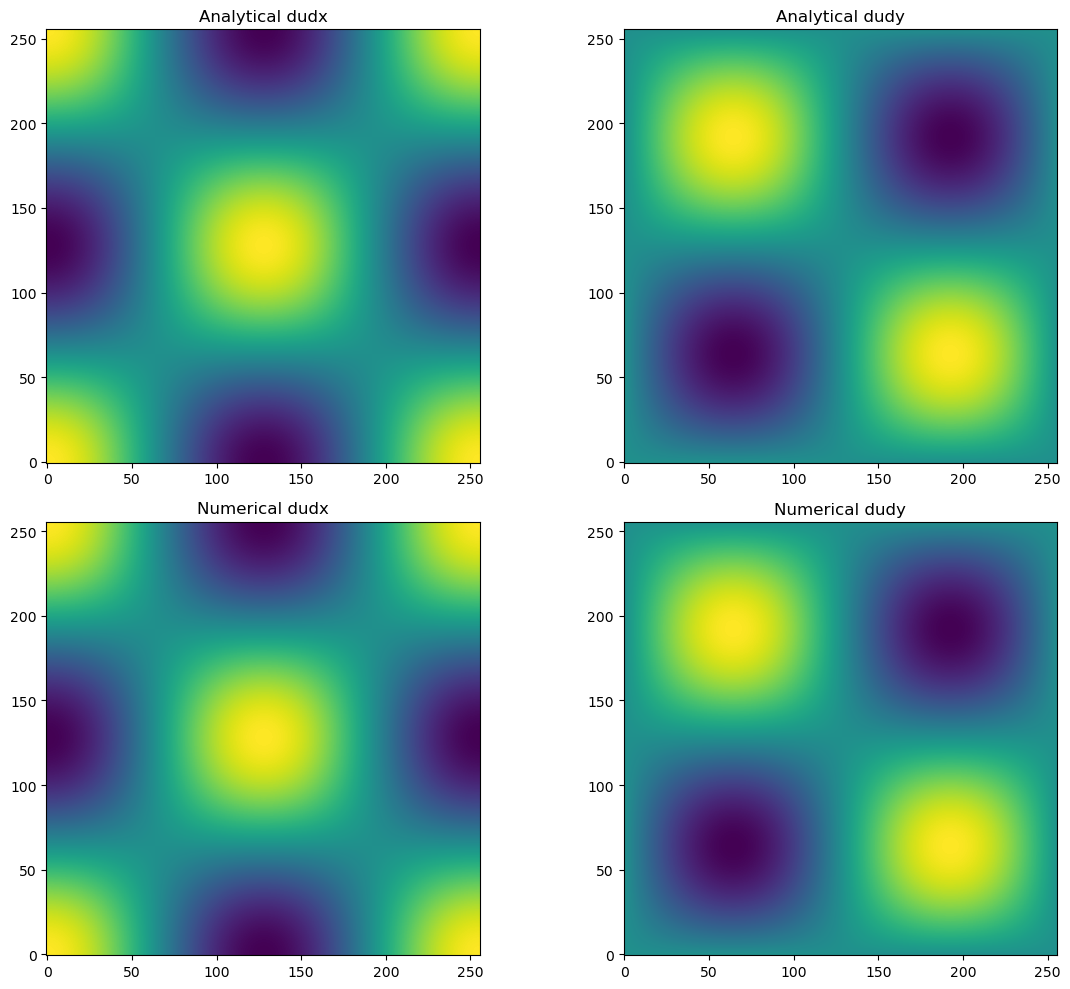

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(dudx_true[..., 0], origin='lower')
axes[0, 0].set_title('Analytical dudx')
axes[0, 1].imshow(dudy_true[..., 0], origin='lower')
axes[0, 1].set_title('Analytical dudy')
axes[1, 0].imshow(dudx[..., 0], origin='lower')
axes[1, 0].set_title('Numerical dudx')
axes[1, 1].imshow(dudy[..., 0], origin='lower')
axes[1, 1].set_title('Numerical dudy')
plt.tight_layout()
plt.show()

#### Visualize errors

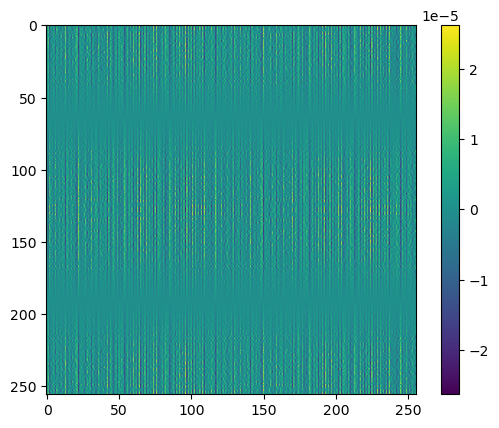

In [8]:
plt.imshow(dudx[..., 0]-dudx_true[..., 0])
plt.colorbar()

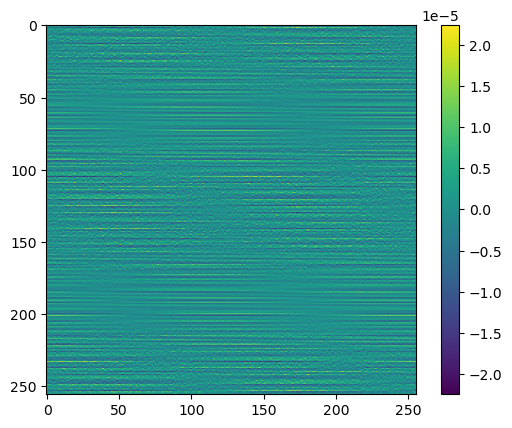

In [9]:
plt.imshow(dudy[..., 0]-dudy_true[..., 0])
plt.colorbar()